In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
# from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

from tqdm import tqdm

from good_robot.location_history_parse import *
from good_robot.gram import layer_to_lines, lines_to_layer
from good_robot import write
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
def layer_to_line_segments(layer):
    nans = np.where(np.isnan(layer[0,:]))[0]
    if nans.size > 0:
        breaks = np.concatenate([np.array([-1]),nans])
        segs = []
        for i in range(len(breaks)-1):
            _line = layer[:,breaks[i]+1:breaks[i+1]].T
            segs.append(_line)
    elif nans.size == 0:
        segs = [layer.T]
    return segs

def join_segs(segments, seg_join_dist_thresh = 0.05):
    segs = segments.copy()
    joined_segs = []
    i = 0
    current_seg = segs.pop(0)
    next_seg = segs.pop(0)
    while len(segs):

        delta = next_seg[0,:] - current_seg[-1,:]
        dpos = (delta ** 2).sum() ** 0.5
        if dpos < seg_join_dist_thresh:
            current_seg = np.concatenate([current_seg, next_seg])
            next_seg = segs.pop(0)
        else:
            joined_segs.append(current_seg)
            current_seg = segs.pop(0)
            next_seg = segs.pop(0)
    return joined_segs

In [ ]:
%%time
filepath = '/mnt/c/data/side/Location History/Location History.json'
df = google_location_history_to_df(filepath)

CPU times: user 41.5 s, sys: 20.2 s, total: 1min 1s
Wall time: 1min 2s


In [ ]:
df.to_csv('/mnt/c/data/side/Location History/Location History.csv')

In [ ]:
df.to_parquet('/mnt/c/data/side/Location History/Location History.parquet')

In [ ]:
big_bay_ind = (df['lat'] < 38) & (37.6 < df['lat']) 
big_bay_ind = big_bay_ind & (-122.6 < df['lon']) & (df['lon'] < -122.15)

small_bay_ind = (df['lat'] < 37.9) & (37.75 < df['lat']) 
small_bay_ind = small_bay_ind & (-122.34 < df['lon']) & (df['lon'] < -122.2)

med_bay_ind = (df['lat'] < 37.9) & (37.75 < df['lat']) 
med_bay_ind = med_bay_ind & (-122.34 < df['lon']) & (df['lon'] < -122.2)

In [ ]:
bb = df[big_bay_ind]

In [ ]:
f,ax = plt.subplots()
data = bb.dropna(subset=['dposm'])
data = data.query('dposm > 0')
ax.hexbin(data['dt'], data['dposm'].values, gridsize=100, bins='log', mincnt=1, yscale='log', extent=(0,600, -2,5))

In [ ]:
f,ax = plt.subplots()
ax.set_yscale('log')
sns.distplot(bb['dt'],ax=ax, kde=False, bins = np.linspace(0,600))

In [ ]:
f,ax = plt.subplots()
ax.set_yscale('log')
sns.distplot(bb['dposm'],ax=ax, kde=False, bins = np.linspace(0,600), hist_kws={'log':True})

In [ ]:
front_cols = ['lat', 'lon',   'm_from_hpsc', 'dpos_hpsc', 'dt','dposm', 'mpers',
       'trip_ind', 'trip']

In [ ]:
start='2018-01-14-15:55'
end='2020-06-29-16:10'
data = bb.loc[start:end,:]

In [ ]:
%%time
min_vel=0.01
max_vel=35
max_dt=300
max_dposm=1000

trip_times, split_ind =  split_trips(
    data,
    min_vel=min_vel,
    max_vel=max_vel,
    max_dt=max_dt,
    max_dposm=max_dposm,
)

CPU times: user 37.8 s, sys: 78.1 ms, total: 37.9 s
Wall time: 39.1 s


In [ ]:
%%time
min_vel=0.01
max_vel=35
max_dt=300
max_dposm=1000

is_trip =  get_is_trip_bool(
    data,
    min_vel=min_vel,
    max_vel=max_vel,
    max_dt=max_dt,
    max_dposm=max_dposm,
)
data['is_trip'] = is_trip
data['trip_starts'], data['trip_ends'], data['trips'] = get_trip_time_bools(data, is_trip)

<timed exec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 203 ms, sys: 15.6 ms, total: 219 ms
Wall time: 214 ms


<timed exec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# split into trips
_data = data.query('is_trip').loc[:,['trip_starts', 'lat','lon']]
trip_starts_ind = np.where(_data['trip_starts'])[0]
trips = np.split(_data.loc[:,['lon','lat',]].values, trip_starts_ind)

(-122.61489528, -122.12816992, 37.58024566, 38.06697102)

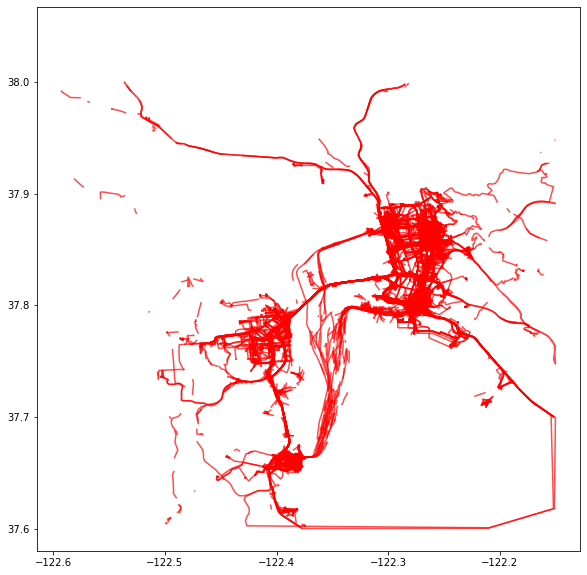

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
lc = LineCollection(trips, alpha=0.7, color='r')
ax.add_collection(lc,)
ax.axis('tight')
ax.axis('square')

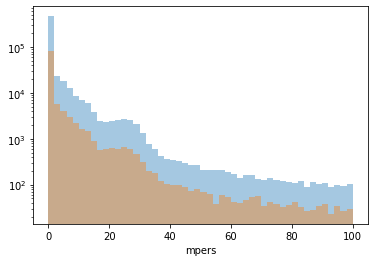

In [ ]:
f,ax = plt.subplots()
# sns.distplot(data.dropna(subset=['heading'])['mpers'],kde=False, hist_kws={'log':True,'range':(0,40)},)
sns.distplot(data['mpers'],kde=False, hist_kws={'log':True,'range':(0,100)}, )
sns.distplot(data.dropna(subset=['in_vehicle'])['mpers'],kde=False, hist_kws={'log':True,'range':(0,100)},)

In [ ]:
%%time

lines = []
for i, trip_time in tqdm(enumerate(trip_times)):
    start,end = trip_time
    trip = data.loc[start:end,:]
    line = trip.loc[:,['lon', 'lat']].values
    lines.append(line)

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 79390/79390 [01:22<00:00, 967.62it/s] 

CPU times: user 1min 20s, sys: 3.2 s, total: 1min 23s
Wall time: 1min 22s


In [ ]:
joined_lines = join_segs(lines[:1000])

In [ ]:
seg_join_dist_thresh = 0.005

In [ ]:
joined_lines = []
this_line = None
for i in tqdm(range(len(lines[:1000]))):
    if this_line is None:
        this_line = lines[i]
    else:
        delta = lines[i] - this_line[-1,:]
        dpos = (delta ** 2).sum() ** 0.5
        if dpos < seg_join_dist_thresh:
            this_line = np.concatenate([this_line, lines[i]])
        else:
            joined_lines.append(this_line)
            this_line = None

100%|██████████| 1000/1000 [00:00<00:00, 31022.27it/s]


In [ ]:
len(joined_lines)

96

In [ ]:
line_lens = [len(line) for line in lines]

In [ ]:
long_lines = []
for i, line_len in enumerate(line_lens):
    if line_len > 10:
        long_lines.append(lines[i])

In [ ]:
line_picks = np.random.choice(len(lines), size=100000, replace=False)
line_samples = [lines[lp] for lp in line_picks]

(-122.42694503999998, -122.23569816, 37.76343349, 37.95468036999998)

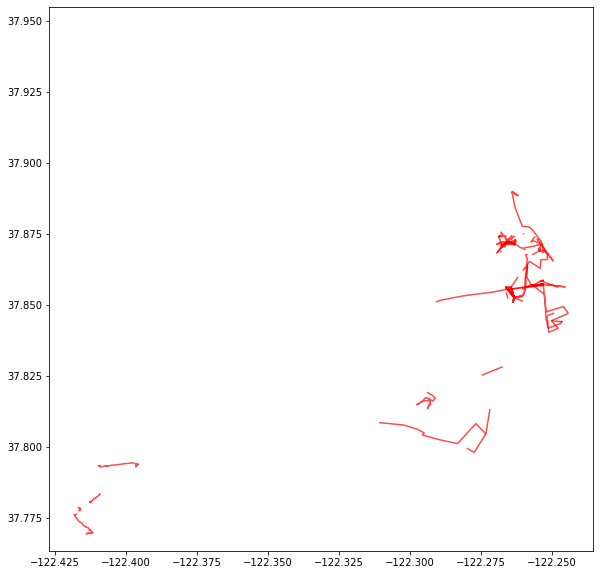

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
lc = LineCollection(joined_lines, alpha=0.7, color='r')
ax.add_collection(lc,)
ax.axis('tight')
ax.axis('square')

In [ ]:
layer = lines_to_layer(long_lines)

In [ ]:
from pathlib import Path

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0022_loc_hist.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[layer], filename=save_filepath, margin=0.2)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.hexbin(layer[0], layer[1], gridsize=300, bins='log', mincnt=1,)

In [ ]:
start_points = np.stack([line[0,:] for line in lines])
end_points = np.stack([line[-1,:] for line in lines])

In [ ]:
sps = np.stack(start_points)
eps = np.stack(end_points)
start_ends = np.concatenate([sps, eps], axis=1)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.hexbin(sps[:,0], sps[:,1], gridsize=300, bins='log', mincnt=1,)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(sps) 

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(14,7))

axs[0].hexbin(sps[:,0], sps[:,1], gridsize=100, bins='log', mincnt=1)

axs[1].hexbin(sps[:,0], sps[:,1], gridsize=300, bins='log', mincnt=1, alpha=0.1)
for i, cc in enumerate(kmeans.cluster_centers_):
    axs[1].plot(cc[0],cc[1],marker=f'${i}$', markersize=15)

In [ ]:
centroids = [kmeans.cluster_centers_[i] for i in [5, 7, 0, 2, 1, 4]]

In [ ]:
start_point_dist_vecs = []
for centroid in centroids:
    start_point_dist_vec = ((sps - centroid) ** 2).sum(axis=1) ** 0.5
    start_point_dist_vecs.append(start_point_dist_vec)

dists_from_centroid = np.stack(start_point_dist_vecs).T

In [ ]:
max_dists = np.array([0.0001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005])
near_centroids = (dists_from_centroid < max_dists)
not_near_any_centroid = ~near_centroids.any(axis=1)
not_near_centroid_lines = [lines[i] for i in np.where(not_near_any_centroid)[0]]

In [ ]:
lines_subset

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0020_loc_hist.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[layer], filename=save_filepath, margin=0.2)

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
lc = LineCollection(not_near_centroid_lines, alpha=0.2, color='k')
ax.add_collection(lc,)
ax.axis('tight')
ax.axis('square')

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
lc = LineCollection(lines, alpha=0.2, color='k')
ax.add_collection(lc,)
lines_in_centroid = []
line_collections = []
for i in range(6):
    near_centroid_inds = np.where(near_centroids[:,i])[0]
    lines_in_centroid.append([lines[nci] for nci in near_centroid_inds])
    line_collections.append(LineCollection(lines_in_centroid[i], alpha=0.7, color='r'))
    ax.add_collection(line_collections[i])
    
ax.axis('tight')
ax.axis('square')

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
lc = LineCollection(lines, alpha=0.7, color='k')
ax.add_collection(lc,)
lc = LineCollection(close_lines, alpha=0.7, color='r')
ax.add_collection(lc,)
ax.axis('tight')
ax.axis('square')

In [ ]:

xmin = data.index.min()
xmax = data.index.max()

f, axs = plt.subplots(5, 1, figsize=(14,8), sharex=True)

ax = axs[0]
var = 'dposm'
ax.plot(data[var], '-o',)
ax.hlines(y=max_dposm, xmin=xmin, xmax=xmax, linestyle=':', color='r')
ax.set_ylim((-10,400))

ax = axs[1]
var = 'mpers'
# ax.set_yscale('log')
ax.plot(data[var], '-o', label='smoothed')
ax.hlines(y=max_vel, xmin=xmin, xmax=xmax, linestyle=':', color='r')
ax.hlines(y=min_vel, xmin=xmin, xmax=xmax, linestyle=':', color='r')
ax.set_ylim((-5,100))

ax = axs[2]
var = 'dt'
ax.plot(data[var], '-o', label='smoothed')
ax.hlines(y=max_dt, xmin=xmin, xmax=xmax, linestyle=':', color='r')

ax = axs[3]
var = 'lat'
ax.plot(data[var], '-og',)

ax = axs[4]
var = 'lon'
ax.plot(data[var], '-og',)

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
ax.plot(bb_samp['lat'], bb_samp['lon'], '.k', alpha=0.05)
ax.plot(_bb['lat'], _bb['lon'], '-o', alpha=0.5)
ax.plot(_bbm['lat'], _bbm['lon'], '-o', alpha=0.5)
ax.axis('tight')
ax.axis('square')

In [ ]:
start='2019-03-11-08'
end='2019-03-11-20'
_bb = bb.loc[start:end,:]
_bbm = bbm.loc[start:end,:]
_bbss = bbss.loc[start:end,:]

In [ ]:
data = _bbss

In [ ]:
def get_trip_starts_and_ends(data):
    moving_ind = (data['moving'] > data['still'])
    start_inds = np.where((moving_ind.astype(int).diff() == 1))[0]
    end_inds = np.where((moving_ind.astype(int).diff() == -1))[0]
    trip_start_times = [data.iloc[start_ind].name for start_ind in start_inds]
    trip_end_times = [data.iloc[end_ind].name for end_ind in end_inds]
    return trip_start_times, trip_end_times

In [ ]:
trip_start_times, trip_end_times = get_trip_starts_and_ends(_bbss)

In [ ]:
lines = []
for start, end in zip(trip_start_times, trip_end_times):
    trip = df.loc[start:end,:]
    line = trip.loc[:,['lat', 'lon']].values
    lines.append(line)

In [ ]:
f,ax = plt.subplots(figsize=(12,12))
# lc = LineCollection(lines, alpha=0.1)
# ax.add_collection(lc)
ax.plot(_bb['lat'], _bb['lon'])
for line in lines:
    ax.plot(line[:,0], line[:,1], '-or')
ax.axis('tight')
ax.axis('square')

In [ ]:
trip_dist = _data['dpos'].sum()

In [ ]:
trip_dist

In [ ]:
start=18010
end=18100
_df = df.loc[start:end,:]

buffer = 0.16

xmin = _df['lon'].min() - buffer
xmax = _df['lon'].max() + buffer
ymin = _df['lat'].min() - buffer
ymax = _df['lat'].max() + buffer


f,ax = plt.subplots(figsize=(10,10))

ax.plot(bb['lon'], bb['lat'], '.b', alpha=0.1)
ax.plot(_df['lon'], _df['lat'], '-or', alpha=0.8)

ax.axis('square')

ax.plot(_df['dpos'])
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))

In [ ]:
f,ax = plt.subplots(figsize=(12,6))
# start=10720
# end=10800
start=18010
end=18100
_df = df.loc[start:end,:]
ax.plot(_df['dpos'])


In [ ]:
jump_ind = (lower_lim > df['dpos']) | (df['dpos']>upper_lim)
df.loc[jump_ind,['lat','lon']] = np.nan



In [ ]:
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp_ms'] = df_gps['locations'].map(lambda x: x['timestampMs'])

# convert lat/lon to decimalized degrees and the timestamp to date-time
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7
df_gps['timestamp_ms'] = df_gps['timestamp_ms'].astype(float) / 1000

In [ ]:
df_gps['datetime'] = df_gps['timestamp_ms'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
date_range = '{}-{}'.format(df_gps['datetime'].min()[:4], df_gps['datetime'].max()[:4])

In [ ]:
df_gps.loc[1:,'dlat'] = df_gps['lat'].diff()
df_gps.loc[1:,'dlon'] = df_gps['lon'].diff()
df_gps['dpos'] = (df_gps['dlat']**2 + df_gps['dlon']**2) ** 0.5

In [ ]:
df.loc[5,'locations']

In [ ]:
len(joined_segs)

In [ ]:
df.shape

In [ ]:
lower_lim = 0.0001
upper_lim = 0.007
seg_join_dist_thresh = 0.005


df = df_gps.copy()
df = df[small_bay_ind]
jump_ind = (lower_lim > df['dpos']) | (df['dpos']>upper_lim)
df.loc[jump_ind,['lat','lon']] = np.nan

df.loc[1:,'dlat'] = df['lat'].diff()
df.loc[1:,'dlon'] = df['lon'].diff()
df['dpos'] = (df['dlat']**2 + df['dlon']**2) ** 0.5
jump_ind = (lower_lim > df['dpos']) | (df['dpos']>upper_lim)
df.loc[jump_ind,['lat','lon']] = np.nan
_data = df.tail(350000)
# _data = df

f, ax = plt.subplots(figsize=(8,8))
segs = layer_to_line_segments(_data.loc[:,['lon','lat']].values.T)
segs = [seg for seg in segs if seg.shape[0]>0]
joined_segs = join_segs(segs, seg_join_dist_thresh=seg_join_dist_thresh)
line_segments = LineCollection(joined_segs)
ax.add_collection(line_segments)
# ax.plot(_data['lon'],_data['lat'],'o',markersize=1,alpha=0.02)
ax.axis('tight')
ax.axis('equal')
ax.axis('off');

In [ ]:
savedir='/Users/naka/Pictures/axidraw/'
f.savefig(savedir+'smallbay_lines2.svg',dpi=300)

In [ ]:
savedir='/Users/naka/Pictures/axidraw/'
f.savefig(savedir+'closebay_lines_smol5.svg',dpi=300)

In [ ]:
f, ax = plt.subplots(figsize=(11,8.5))
data = _df.query('37.6 < lat < 37.9').query('-122.5 < lon < -122.23')
# _data = data.sample(50000)
# _data = data.head(100000)
# ax.scatter(_data['lon'],_data['lat'],s=1,alpha=1)
ax.plot(_data['lon'],_data['lat'],alpha=0.3)
ax.axis('equal');
ax.axis('off')

In [ ]:
savedir='/Users/naka/Pictures/axidraw/'
f.savefig(savedir+'closebay50k.svg',dpi=300)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))

# data = df_gps.query('37.75 < lat < 37.9').query('-122.34 < lon < -122.2')
data = df_gps[big_bay_ind]
# _data = data.sample(100000)
_data = data
ax.scatter(_data['lon'],_data['lat'],s=1,alpha=0.1)
ax.axis('equal');
# ax.axis('off')

In [ ]:
sns.set_style('dark')

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
# data = df_gps.query('37.75 < lat < 37.9').query('-122.34 < lon < -122.2')
data = df_gps[big_bay_ind]
_data = data
ax.hexbin(_data['lon'],_data['lat'], gridsize=3000, bins='log', mincnt=1)
ax.axis('tight')
ax.axis('equal')
ax.axis('off')

In [ ]:
f.savefig('bigbay2.png',dpi=300)

In [ ]:

sns.distplot(data['lon'], bins=50, kde=False)

In [ ]:
sns.distplot(df_gps.query('37.5 < lat < 38.2')['lat'], bins=50, kde=False)